In [32]:
import numpy as np
# IMPORT LIBRARIES AND DATASET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from scipy.signal import savgol_filter
from obspy.signal.detrend import polynomial

df = pd.read_csv('dataset/rgs_peach_brix.csv')
# Brix data
y = df['Brix'].values
# Absorbance data
X = df.drop(['Brix'], axis=1).values
# each spectrum is taken over 600 wavelength points, from 1100 nm to 2300 nm in steps of 2 nm
wls = np.arange(1100,2300,2)

In [33]:
# MIN-MAX SCALER
def MMS(input_spectra):
    return MinMaxScaler().fit_transform(input_spectra)

In [34]:
def SS(input_spectra):
    return StandardScaler().fit_transform(input_spectra)

In [36]:
# MSC - MULTIPLICATIVE SCATTER CORRECTION

def msc(input_spectra, reference=None):
    # Mean center correction
    for i in range(input_spectra.shape[0]):
        input_spectra[i,:] -= input_spectra[i,:].mean()
    # Get the reference spektrum. If no given, estimate it from the mean
    if reference is None:
        # Calculate mean
        ref = np.mean(input_spectra, axis=0)
    else:
        ref = reference
    # Define a new array and populate it with the corrected data
    data_msc = np.zeros_like(input_spectra)
    for i in range(input_spectra.shape[0]):
        # Run regression
        fit = np.polyfit(ref, input_spectra[i,:], 1, full=True)
        # Apply correction
        data_msc[i,:] = (input_spectra[i,:] - fit[0][1]) / fit[0][0]

    return data_msc, ref
# https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

In [37]:
# STANDARD NORMAL VARIATE
def snv(input_spectra):
    # Define a new array and populate it with the corrected data
    output_data = np.zeros_like(input_spectra)
    for i in range(input_spectra.shape[0]):
        # Apply correction
        output_data[i,:] = (input_spectra[i,:] - np.mean(input_spectra[i,:])) / np.std(input_spectra[i,:])
    return output_data
# https://nirpyresearch.com/two-scatter-correction-techniques-nir-spectroscopy-python/

In [38]:
# SIMPLE MOVING AVERAGE
def sma(input_spectra, window_size):
    df = pd.DataFrame(input_spectra)
    moving_averages = df.rolling(window_size).mean()
    return moving_averages

In [39]:
# SAVITZKY-GOLAY SMOOTHING
def SG_smoothing(input_data, window_size, polyorder):
    SG_smoothing =savgol_filter(input_data,
                                window_length=window_size,
                                polyorder=polyorder,
                                mode="nearest")
    return SG_smoothing
# https://www.datatechnotes.com/2022/05/smoothing-example-with-savitzky-golay.html

In [40]:
# SAVITZKY-GOLAY DERIVATIVE/FILTER
def SG_derivative(input_data, window_size, polyorder, derivative):
    SG_filter = savgol_filter(input_data,
                              window_length=window_size,
                              polyorder=polyorder,
                              deriv=derivative,
                              delta=1.0,
                              axis=-1,
                              mode='interp', #'nearest'
                              cval=0.0)
    return SG_filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html

In [41]:
# DE-TRENDING / DT (TREND CORRECTION)
def dt(input_spectra, wavelength):
    output = np.array(input_spectra)
    l = LinearRegression()
    for i in range(output.shape[0]):
        l.fit(wavelength.reshape(-1,1), output[i].reshape(-1,1))
        k = l.coef_
        b = l.intercept_
        for j in range(output.shape[1]):
            output[i][j] =  output[i][j] - (j * k + b)
    return output

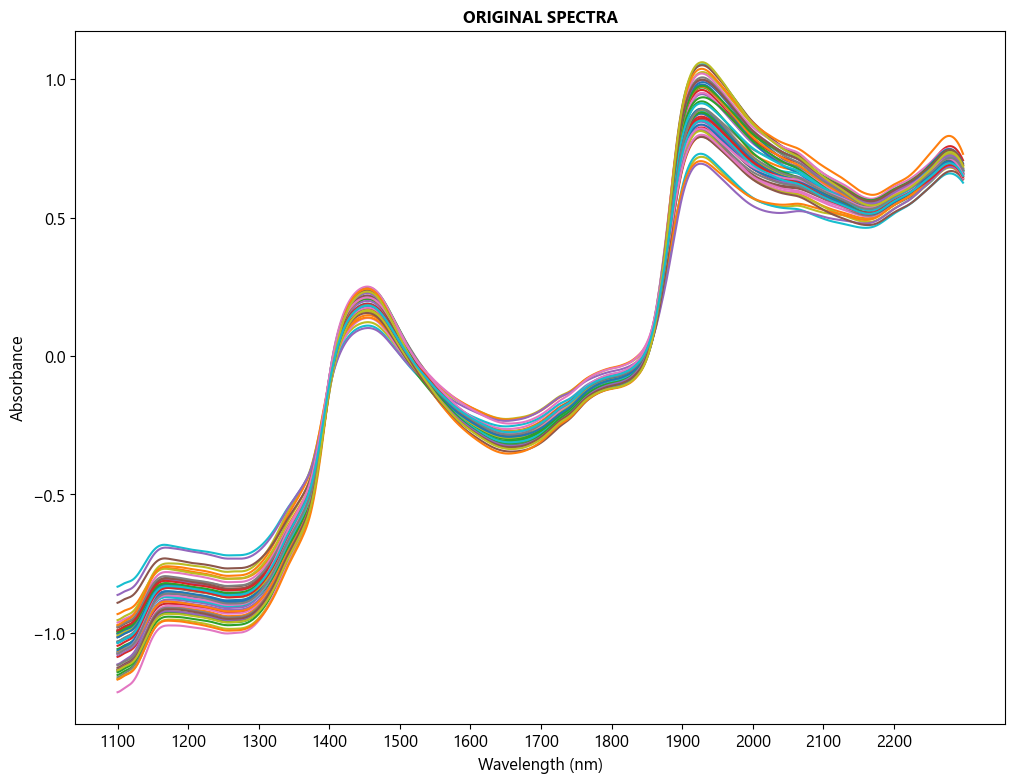

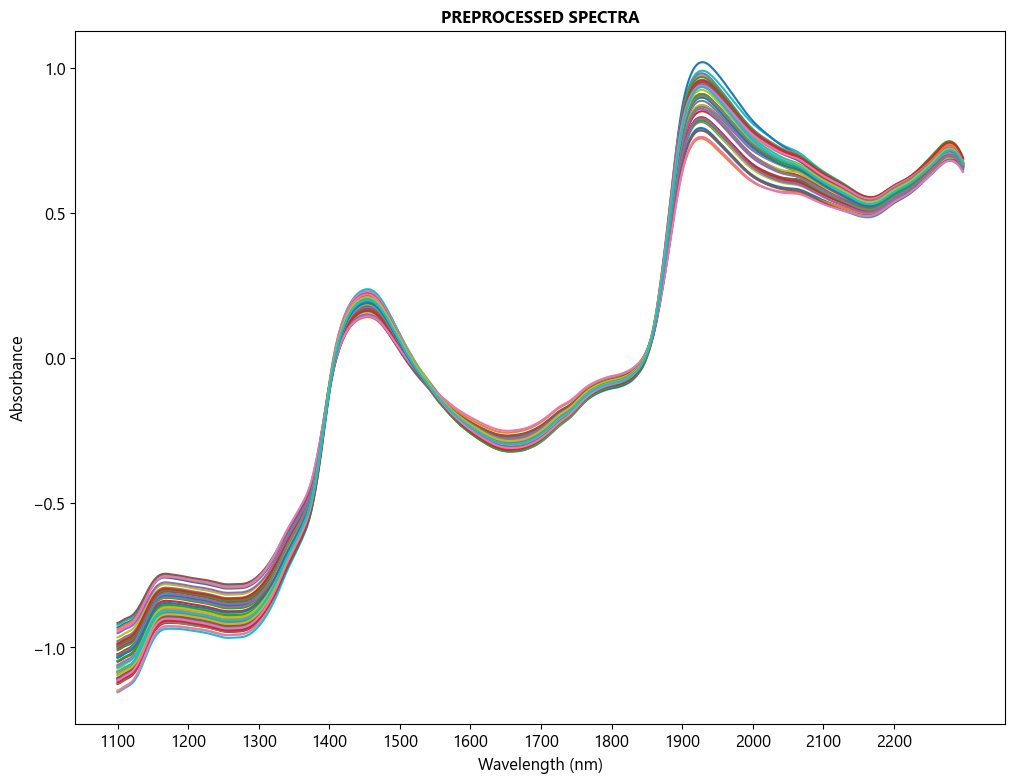

In [55]:
# RUN PROGRAM
if __name__ == '__main__':
    # PLOT ORIGINAL SPECTRA
    plt.figure(figsize=(12, 9))
    plt.plot(wls, np.transpose(X))
    plt.xticks(np.arange(1100, 2300, step=100), fontsize=12, fontname="Segoe UI")
    plt.yticks(fontsize=12, fontname="Segoe UI")
    plt.title('ORIGINAL SPECTRA', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Absorbance', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.plot()

    # PLOT PRE-PROCESSED SEPETRA
    Xmms = MMS(X)
    Xss = SS(X)
    Xmsc = msc(X)[0]
    Xsnv = snv(X)
    Xsma = sma(X,3)
    Xsgf = SG_derivative(X, 17, 2, 2)
    Xsgs = SG_smoothing(X, 15, 3)

    #保存预处理后的数据
    #save_path = 'd://z/research/spectroscopy/dataset'
    #np.savetxt(save_path, Xmsc, delimiter=',')

    plt.figure(figsize=(12, 9))
    plt.plot(wls, Xsma.T)
    plt.xticks(np.arange(1100, 2300, step=100), fontsize=12, fontname="Segoe UI")
    plt.yticks(fontsize=12, fontname="Segoe UI")
    plt.title('PREPROCESSED SPECTRA', fontweight='bold', fontsize=12, fontname="Segoe UI")
    plt.ylabel('Absorbance', fontsize=12, fontname="Segoe UI")
    plt.xlabel('Wavelength (nm)', fontsize=12, fontname="Segoe UI")
    plt.plot()
